# Community Detection

In [Chapter 6](#link?) we learned how to estimate the parameters for an SBM via Maximum Likelihood Estimation (MLE). Unfortunately, we have skipped a relatively fundamental problem with SBM parameter estimation. You will notice that everything we have covered about the SBM to date assumes that we the assignments to one of $K$ possible communities for each node, which is given by the node assignment variable $z_i$ for each node in the network. Why is this problematic? Well, quite simply, when we are learning about *many* different networks we might come across, we might not actually *observe* the communities of each node.

Consider, for instance, the school example we have worked extensively with. In the context of the SBM, it makes sense to guess that two individuals will have a higher chaance of being friends if they attend the same school than if they did not go to the same school. Remember, when we knew what school each student was from and could *order* the students by school ahead of time, the network looked like this:

In [11]:
from graphbook_code import draw_multiplot
from graspologic.simulations import sbm
import numpy as np

ns = [50, 50]  # network with 100 nodes
B = [[0.5, 0.2], [0.2, 0.5]]  # block matrix

# sample a single simple adjacency matrix from SBM(z, B)
A = sbm(n=ns, p=B, directed=False, loops=False)
zs = [1 for i in range(0, 50)] + [2 for i in range(0, 50)]

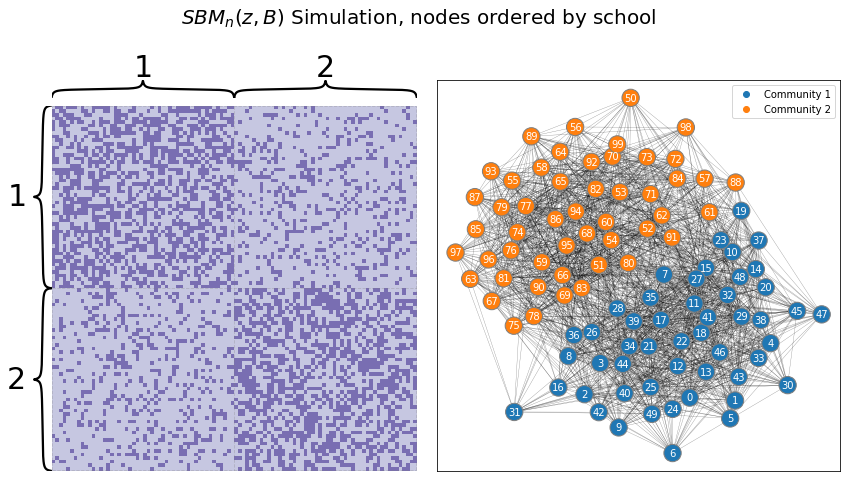

In [12]:
draw_multiplot(A, labels=zs, title="$SBM_n(z, B)$ Simulation, nodes ordered by school");

The block structure is *completely obvious*, and it seems like we could almost just guess which nodes are from which communities by looking at the adjacency matrix (with the proper ordering). Ant therein lies the issue: if we did not know which school each student was from, we would have *no way* of actually using the technique we described in the preceding chapter to estimate parameters for our SBM. If our nodes were just randomly ordered, we might see something instead like this:

In [9]:
# generate a reordering of the n nodes
vtx_perm = np.random.choice(np.sum(ns), size=np.sum(ns), replace=False)

Aperm = A[tuple([vtx_perm])] [:,vtx_perm]

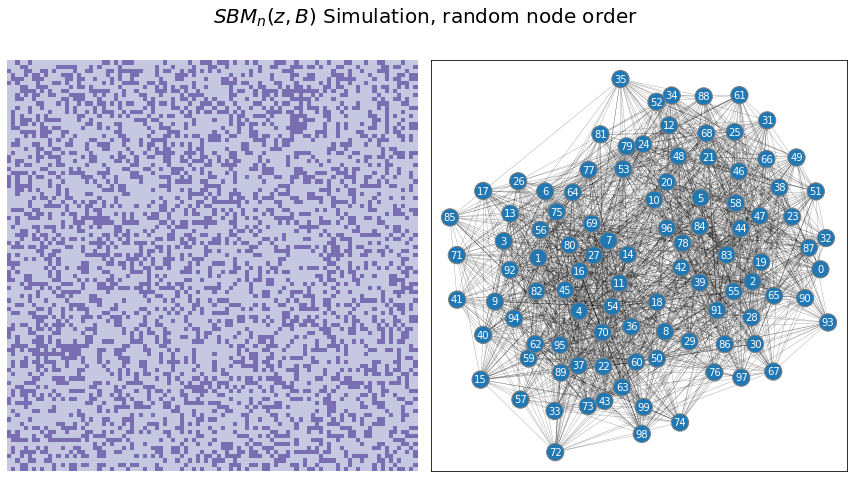

In [10]:
draw_multiplot(Aperm, title="$SBM_n(z, B)$ Simulation, random node order");

It is extremely unclear which nodes are in which community, because there is no immediate block structure to the network. So, what *can* we do?

In fact, the way we will proceed by using the technique we devised for RDPGs, and then we will use this technique for RDPG estimation to produce meaningful community assignments for our nodes. Effectively, what we will do is we will use a clever technique we discussed in [Chapter 6](#link?), called an *embedding*, to learn not only about each edge, but to *learn about each node in relation to all of the other nodes*. What do we mean by this? What we mean is that, while looking at a single edge in our network, we only have two possible choices: the edge exists or it does not exist. However, if we instead consider nodes in *relation* to one another, we can start to deduce patterns about how our nodes might be organized in the community sense. While seeing that two students Bill and Stephanie were friends will not tell us whether Bill and Stephanie were in the same school, if we knew that Bill and Stephanie also shared many other friends (such as Denise, Albert, and Kwan), and those friends also tended to be friends, that piece of information might tell us that they all might happen to be school mates. 

The embedding technique we employ, the *spectral embedding*, allows us to pick up on these *community* sorts of tendencies. When we call a set of nodes a **community** in the context of a network, what we mean is that these nodes tend to be more connected (more edges exist between and amongst them) than with other nodes in the network. The spectral embeddings will help us to identify these communities of nodes, and hopefully, when we review the communities of nodes we learn, we will be able to derive some sort of insight. For instance, in our school example, ideally, we might pick up on two communities of nodes, one for each school. The process of learning community assignments for nodes in a network is known as **community detection**.


## Stochastic Block Model with unknown communities

### Number of communities $K$ is known

When we know the number of communities (even if we don't know which community each node is in), the procedure for fitting a Stochastic Block Model to a network is relatively straightforward. Let's consider a similar example to the scenario we had [in our introduction](#link?), but with $3$ communities instead of $2$. We will have a block matrix given by:
\begin{align*}
    B &= \begin{bmatrix}
        0.8 & 0.2 & 0.2 \\
        0.2 & 0.8 & 0.2 \\
        0.2 & 0.2 & 0.8
    \end{bmatrix}
\end{align*}
Which is a Stochastic block model in which the within-community edge probability is $0.8$, and exceeds the between-community edge probability of $0.2$. We will produce a matrix with $100$ nodes in total.

In [17]:
from graspologic.simulations import sbm

ns = [33, 33, 34]
B = [[0.8, 0.2, 0.2],
     [0.2, 0.8, 0.2],
     [0.2, 0.2, 0.8]]

A = sbm(n=ns, p = B)

# the true community labels
y = [0 for i in range(0,ns[0])] + [1 for i in range(0, ns[1])] + [2 for i in range(0, ns[2])]

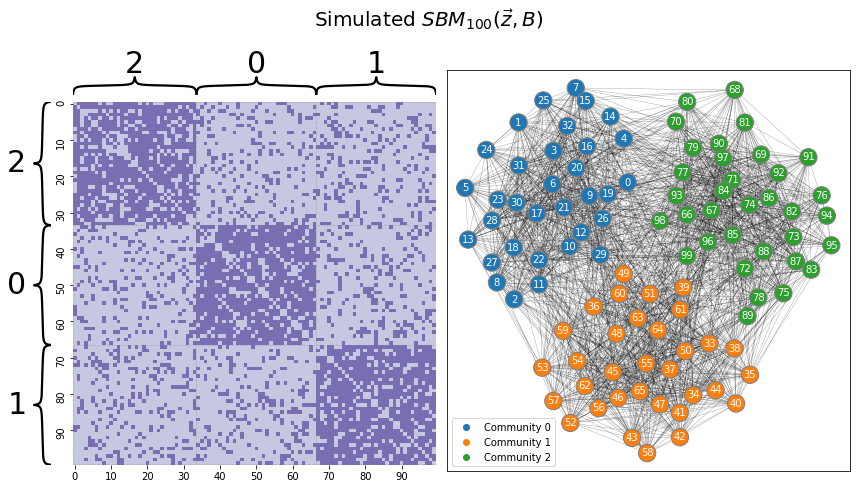

In [25]:
draw_multiplot(A, labels=y, xticklabels=10, yticklabels=10, title="Simulated $SBM_{100}( \\vec z, B)$");

Remember, however, that we do not *actually* know the community labels of each node in $A$, so this problem is a little more difficult than it might seem. If we reordered the nodes, the community each node is assigned to would not be as visually obvious as it is here in this example, as we showed in the [introduction](link?).

Our goal is to learn about the block matrix, $B$, which is the parameter that we care about for the SBM. However, we cannot just plug $A$ into the `SBMEstimator` class like we did back when we [fit an SBM using MLE](link?). This is because the `SBMEstimator` uses node community assignments, which we do not have. Instead, what we will do is turn again to the adjacency spectral embedding, as follows:

```{admonition} Community Detection, number of communities is known
Assuming that we know the number of communities $K$ our network might have, detecting the communities is relatively straightforward:
1. We begin by reduce the observed network $A$ to a an estimated latent position matrix, $\hat X$ using the adjacency spectral embedding. 
2. We will use K-Means clustering (or an alternative clustering technique, such as Gaussian Mixture Model) to assign each node's estimated latent position to one-of-$K$ communities. These will be called our estimates of the community labels for the nodes, $\hat z$.
3. Finally, we will use the communities to which each node is assigned to produce an estimate of the block matrix, $\hat aB$, by using the estimated community labels $\hat z$ in conjunction with the `SBMEstimator` class. 
```

We will demonstrate how to use K-means clustering to infer block labels here. We begin by first embedding $A$ to estimate a latent position matrix:

In [26]:
from graspologic.embed import AdjacencySpectralEmbed

ase = AdjacencySpectralEmbed()  # adjacency spectral embedding, with optimal number of latent dimensions selected using elbow picking
Xhat = ase.fit_transform(A)

How do we explore the estimated latent position matrix $\hat X$ to figure out whether we might be able to uncover useful community assignments for the nodes in our network?

### Pairs Plots

When embedding a matrix using any embedding technique in `graspologic`, it is important to figure out how good that embedding is. One particularly useful way to figure out this "latent structure" (community assignments which are present, but *unknown* by us ahead of time) from a network we suspect might be well-fit by a Stochastic Block Model is known as a "pairs plot". In a pairs plot, we investigate how effectively the embedding "separates" nodes within the dataset into individual "clusters". We will ultimately exploit these "clusters" that appear in the latent positions to generate community assignments for each node. To demonstrate the case where the "pairs plot" shows obvious latent community structure, we will use the predicted latent position matrix we just produced, from an adjacency matrix which is a realization of a random network which is truly a Stochastic Block Model. The pairs plot looks like this:

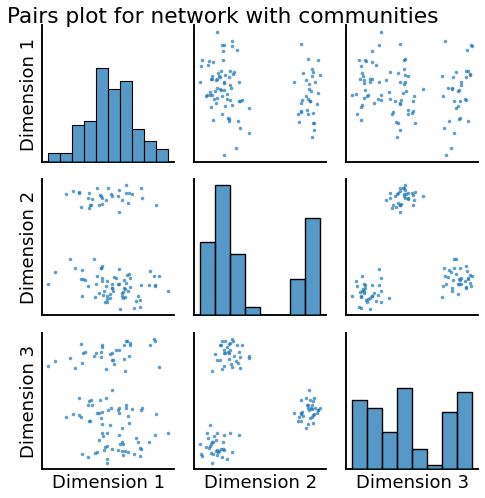

In [28]:
from graspologic.plot import pairplot

_ = pairplot(Xhat, title="Pairs plot for network with communities")

As we can see, the pairs plot is a `d x d` matrix of plots, where `d` is the total number of features of the matrix for which a pairs plot is being produced. For each off-diagonal plot (the plots with the dots), the $k^{th}$ row and $l^{th}$ column scatter plot has the points $(x_{ik}, x_{il})$ for each node $i$ in the network. Stated another way, the off-diagonal plot is a scatter plot for each node of the $k^{th}$ dimension and the $l^{th}$ dimension of the latent position matrix. That these scatter plots indicate that the points appear to be separated into individual clusters provides evidence that there might be community structure in the network.

The diagonal elements of the pairs plot simply represent histograms of latent positions for each dimension. Higher bars indicate that more points have latent position estimates in that range. For instance, the top-left histogram indicates a histogram of the first latent dimension for all nodes, the middle histogram is a histogram of the second latent dimension for all nodes, so on and so forth.

Next, we will show a brief example of what happens when adjacency spectral embedding does not indicate that there is latent community structure. Our example network here will be a realization of a random network which is ER, with a probability of $0.5$ for an edge existing between any pair of nodes. As an ER network does not have community structure, we wouldn't expect the pairs plot to indicate that there are obvious clusters. 

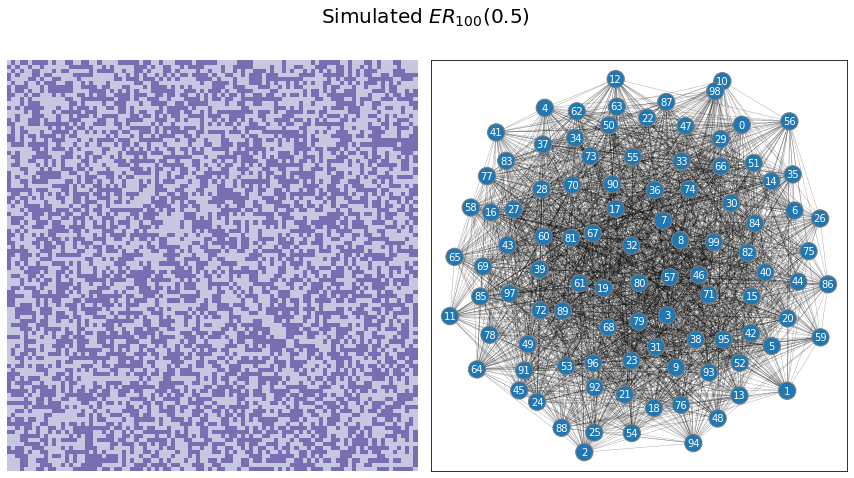

In [29]:
from graspologic.simulations import er_np

A_er = er_np(n=100, p = 0.5)
draw_multiplot(A_er, title="Simulated $ER_{100}(0.5)$");

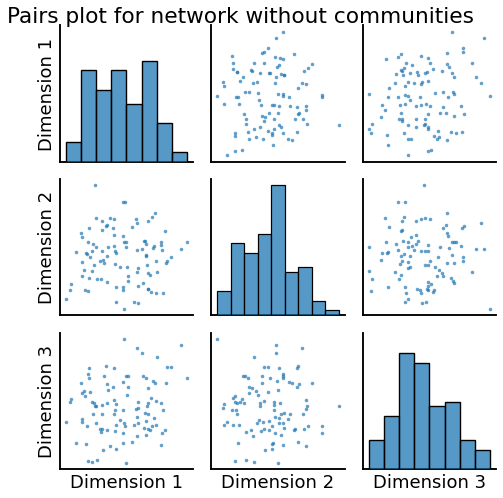

In [30]:
ase_er = AdjacencySpectralEmbed(n_components=3)  # adjacency spectral embedding, with optimal number of latent dimensions selected using elbow picking
Xhat_er = ase_er.fit_transform(A_er)

_ = pairplot(Xhat_er, title="Pairs plot for network without communities")

Unlike with the SBM, we can't see any obvious clusters in this pairs plot.

Next, let's return to our SBM example and obtain some predicted community assignments for our points. Since we do not have any information as to which cluster each node is assigned to, we must use an unsupervised clustering method. We will use the `KMeans` function from `sklearn`'s cluster module to do so. Since we know that the SBM has 3 communities, we will use 3 clusters for the KMeans algorithm. The clusters produced by the `KMeans` algorithm will be our "predicted" community assignments.

In [ ]:
from sklearn.cluster import KMeans

labels_kmeans = KMeans(n_clusters = 3).fit_predict(Xhat)

Since we have simulated data, we have the benefit of being able to evaluate the quality of our predicted community assignments to the true community assignments. We will use the *Adjusted Rand Index* (ARI), which is a measure of the clustering accuracy. A high ARI (near $1$) indicates that the predicted community assignments are good relative the true community assignments, and a low ARI (near $0$) indicates that the predicted community assignments are not good relative the true community assignments. The ARI is agnostic to the names of the different communities, which means that even if the community labels assigned by unsupervised learning do not match the community labels in the true realized network, the ARI is still a legitimate statistic we can investigate. We will look more at the implications of this in the following paragraph.

In [ ]:
from sklearn.metrics import adjusted_rand_score

ari_kmeans = adjusted_rand_score(labels_kmeans, y)
print("ARI(predicted communities, true communities) = {}".format(ari_kmeans))

The ARI of $1$ indicates that the true communities and the predicted communities are in complete agreement!

When using unsupervised learning to learn about labels (such as, in this case, community assignments) for a given set of points (such as, in this case, the latent positions of each of the $n$ *nodes* of our realized network), a truly unsupervised approach knows *nothing* about the true labels for the set of points. This has the implication that the assigned community labels may not make sense in the context of the true labels, or may not align. For instance, a predicted community of $2$ may not mean the same thing as the true community being $2$, since the true community assignments did not have any *Euclidean* relevance to the set of points we clustered. This means that we may have to remap the labels from the unsupervised learning predictions to better match the true labels so that we can do further diagnostics. For this reason, the `graspologic` package offers the `remap_labels` utility function:

In [ ]:
from graspologic.utils import remap_labels

labels_kmeans_remap = remap_labels(y, labels_kmeans)

We can use these remapped labels to understand when `KMeans` is, or is not, producing reasonable labels for our investigation. We begin by first looking at a pairs plot, which now will color the points by their assigned community:

In [ ]:
pairplot(Xhat,
         labels=labels_kmeans_remap,
         title=f'KMeans on embedding, ARI: {str(ari_kmeans)[:5]}',
         legend_name='Predicted label',
         height=3.5,
         palette='muted',);

The final utility of the pairs plot is that we can investigate which points, if any, the clustering technique is getting wrong. We can do this by looking at the classification error of the nodes to each community:

In [ ]:
error = y - labels_kmeans_remap  # compute which assigned labels from labels_kmeans_remap differ from the true labels y
error = error != 0  # if the difference between the community labels is non-zero, an error has occurred
er_rt = np.mean(error)  # error rate is the frequency of making an error

palette = {'Right':(0,0.7,0.2),
           'Wrong':(0.8,0.1,0.1)}

error_label = np.array(len(y)*['Right'])  # initialize numpy array for each node
error_label[error] = 'Wrong'  # add label 'Wrong' for each error that is made

pairplot(Xhat,
         labels=error_label,
         title=f'Error from KMeans, Error rate: {str(er_rt)}',
         legend_name='Error label',
         height=3.5,
         palette=palette,);

Great! Our classification has not made any errors.

To learn about the block matrix $B$, we can now use the `SBMEstimator` class, with our predicted labels:

In [ ]:
from graspologic.models import SBMEstimator

model = SBMEstimator(directed=False, loops=False)
model.fit(A, y=labels_kmeans_remap)
Bhat = model.block_p_

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

heatmap(Bhat,
        vmin=0,
        vmax=1,
        font_scale=1.5,
        title="$\hat B_{SBM}$",
        ax=axs[0])

heatmap(np.array(B),
        vmin=0,
        vmax=1,
        font_scale=1.5,
        title="$B_{SBM}$",
        ax=axs[1])

heatmap(np.abs(Bhat - np.array(B)),
        vmin=0,
        vmax=1,
        font_scale=1.5,
        title="$|\hat B_{SBM} - B_{SBM}|$",
        ax=axs[2])

fig;


```{admonition} Recap of inference for Stochastic Block Model with known number of communities

1. We learned that the adjacency spectral embedding is a key algorithm for making sense of networks which are realizations of SBM random networks. The estimates of latent positions produced by ASE are critical for learning community assignments.
2. We learned that unsuperised learning (such as K-means) allows us to ues the estimated latent positions to learn community assignments for each node in our network. 
3. We can use `remap_labels` to align predicted labels with true labels, if true labels are known. This is useful for benchmarking techniques on networks with known community labels.
4. We evaluate the quality of unsupervised learning by plotting the predicted node labels and (if we know the true labels) the errorfully classified nodes. The ARI and the error rate summarize how effective our unsupervised learning techniques performed.
```

### Number of communities $K$ is not known

In real data, we almost never have the beautiful canonical modular structure obvious to us from a Stochastic Block Model. This means that it is *extremely infrequently* going to be the case that we know exactly how we should set the number of communities, $K$, ahead of time.

Let's first remember back to the single network models section, when we took a Stochastic block model with obvious community structure, and let's see what happens when we just move the nodes of the adjacency matrix around. We begin with a similar adjacency matrix to $A$ given above, for the $3$-community SBM example, but with the within and between-community edge probabilities a bit closer together so that we can see what happens when we experience errors. The communities are still slightly apparent, but less so than before:

In [ ]:
B = [[0.7, 0.45, 0.35],
     [0.45, 0.7, 0.45],
     [0.35, 0.45, 0.7]]
np.random.seed(12)
A = sbm(n=ns, p = B)

# the true community labels
y = [0 for i in range(0,ns[0])] + [1 for i in range(0, ns[1])] + [2 for i in range(0, ns[2])]
draw_multiplot(A, labels=y, xticklabels=10, yticklabels=10, title="Simulated SBM($\pi$, B)");

Next, we permute the nodes around to reorder the realized adjacency matrix:

In [ ]:
# generate a reordering of the n nodes
np.random.seed(123)
vtx_perm = np.random.choice(A.shape[0], size=A.shape[0], replace=False)

A_permuted = A[tuple([vtx_perm])] [:,vtx_perm]
y_perm = np.array(y)[vtx_perm]

In [ ]:
from graphbook_code import heatmap as hm_code 
from graphbook_code import draw_layout_plot as lp_code

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# heatmap
hm = hm_code(
    A_permuted,
    ax=axs[0],
    cbar=False,
    color="sequential",
    xticklabels=10,
    yticklabels=10
)

# layout plot
lp_code(A_permuted, ax=axs[1], pos=None, labels=y_perm, node_color="qualitative")
plt.suptitle("Simulated SBM($\pi, B$), reordered vertices", fontsize=20, y=1.1)
    
fig;

We only get to see the adjacency matrix in the *left* panel; the panel in the *right* is constructed by using the true labels (which we do *not* have!). This means that we proceed for statistical inference about the random network underlying our realized network using *only* the heatmap we have at right. It is not immediately obvious that this is the realization of a random network which is an SBM with $3$ communities.

Our procedure is *very* similar to what we did previously [when the number of communities was known](#link?). We again embed using the "elbow picking" technique:

In [ ]:
ase_perm = AdjacencySpectralEmbed()  # adjacency spectral embedding, with optimal number of latent dimensions selected using elbow picking
Xhat_permuted = ase_perm.fit_transform(A_permuted)

We examine the pairs plot, *just* like in the section on [pairs plots](#link?):

In [ ]:
_ = pairplot(Xhat_permuted, title="SBM adjacency spectral embedding")

We can still see that there is some level of latent community structure apparent in the pairs plot. This is evident from, for instance, the plots of Dimension 2 against Dimension 3, where we can see that the latent positions of respective nodes *appear* to be clustering in some way.

Next, we have the biggest difference with the approach we took previously. Since we do *not* know the optimal number of clusters $K$ *nor* the true community assignments, we must choose an unsupervised clustering technique which allows us to *compare* clusterings with different choices of clusters. We can again perform this using the `KMeans` algorithm that we used previously. Here, we will compare the quality of a clustering with one number of clusters to the quality of a clustering with a *different* number of clusters using the silhouette score. The optimal clustering is selected to be the clustering which has the largest silhouette score across all attempted numbers of clusters.

This feature is implemented automatically in the `KMeansCluster` function of `graspologic`. We will select the number of clusters which maximizes the silhouette score, and will allow at most $10$ clusters total to be produced:

In [ ]:
from graspologic.cluster import KMeansCluster

km_clust = KMeansCluster(max_clusters = 10)
km_clust = km_clust.fit(Xhat_permuted);

Next, we visualize the silhouette score as a function of the number of clusters:

In [ ]:
import seaborn as sns
from pandas import DataFrame as df

nclusters = range(2, 11)  # graspologic nclusters goes from 2 to max_clusters
silhouette = km_clust.silhouette_  # obtain the respective silhouette scores

silhouette_df = df({"Number of Clusters": nclusters, "Silhouette Score": silhouette})  # place into pandas dataframe

fig, ax = plt.subplots(1,1,figsize=(12, 6))

sns.lineplot(data=silhouette_df,ax=ax, x="Number of Clusters", y="Silhouette Score");
ax.set_title("Silhouette Analysis of KMeans Clusterings")
fig;

As we can see, Silhouette Analysis has indicated the best number of clusters as $3$ (which, is indeed, *correct* since we are performing a simulation where we know the right answer). Next, let's take a look at the pairs plot for the optimal classifier. We begin by producing the predicted labels for each of our nodes, and remapping to the true community assignment labels, exactly as we did previously for further analysis:

In [ ]:
labels_autokmeans = km_clust.fit_predict(Xhat_permuted)
labels_autokmeans = remap_labels(y_perm, labels_autokmeans)

ari_kmeans = adjusted_rand_score(labels_autokmeans, y_perm)

pairplot(Xhat_permuted,
         labels=labels_autokmeans,
         title=f'KMeans on embedding, ARI: {str(ari_kmeans)[:5]}',
         legend_name='Predicted label',
         height=3.5,
         palette='muted',);

`KMeans` was still able to find relatively stable clusters, which align quite well (ARI of $0.855$, which is not perfect but closer to $1$ than to $0$!) with the true labels! Next, we will look at which points `KMeans` tends to get *wrong* to see if any patterns arise:

In [ ]:
error = y_perm - labels_autokmeans  # compute which assigned labels from labels_kmeans_remap differ from the true labels y
error = error != 0  # if the difference between the community labels is non-zero, an error has occurred
er_rt = np.mean(error)  # error rate is the frequency of making an error

palette = {'Right':(0,0.7,0.2),
           'Wrong':(0.8,0.1,0.1)}

error_label = np.array(len(y)*['Right'])  # initialize numpy array for each node
error_label[error] = 'Wrong'  # add label 'Wrong' for each error that is made

pairplot(Xhat_permuted,
         labels=error_label,
         title=f'Error from KMeans, Error rate: {str(er_rt)}',
         legend_name='Error label',
         height=3.5,
         palette=palette,);

And there do not appear to be any dramatic issues in our clustering which woul suggest systematic errors are present. To learn about $B$, we would proceed exactly as we did previously, by using these labels with the `SBMEstimator` class to perform inference:

In [ ]:
model = SBMEstimator(directed=False, loops=False)
model.fit(A_permuted, y=labels_autokmeans)
Bhat = model.block_p_

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

heatmap(Bhat,
        vmin=0,
        vmax=1,
        font_scale=1.5,
        title="$\hat B_{SBM}$",
        ax=axs[0])

heatmap(np.array(B),
        vmin=0,
        vmax=1,
        font_scale=1.5,
        title="$B_{SBM}$",
        ax=axs[1])

heatmap(np.abs(Bhat - np.array(B)),
        vmin=0,
        vmax=1,
        font_scale=1.5,
        title="$|\hat B_{SBM} - B_{SBM}|$",
        ax=axs[2])

fig;

Which appears very close to the true $B$. Now, let's do a quick recap of what we've covered so far.

```{admonition} Recap of inference for Stochastic Block Model with unknown number of communities

1. The Adjacency Spectral Embedding is used to generate *estimates of latent positions*. We verify the quality of these estimates using pairs plots.
2. We use unsupervised learning with an objective quality metric (such as the silhoutte score) to learn both the number of communities *and* the community assignment for nodes within our network. The use of an objective quality metric that allows us to evaluate classification performance across different numbers of communities is the key difference between how we perform inference with unknown community labels when we knew vs did not know the number of communities in our network.
3. We *align* the labels produced by unsupervised learning with true labels for our network using `remap labels`. 
4. We evaluate the nuances of the unsupervised learning technique using pairs plots colored with the predicted labels, and the classification errors. Again, we ue the ARI and the error rate to evaluate classifier performance.
```